# Part 2


In [1]:
import numpy as np
from scipy.signal import argrelextrema


def extract_growth_features(df, id_col="gen1_id", age_col="age", height_col="SHgt_cm"):
    """Extract mid-growth spurt (MS) and pubertal spurt (PS) features"""
    feature_list = []

    for subject_id, data in df.groupby(id_col):
        data = data.sort_values(age_col)
        ages = data[age_col].values
        heights = data[height_col].values

        velocity = np.gradient(heights, ages)
        velocity[np.isnan(velocity)] = 0  # impute with 0

        acceleration = np.gradient(velocity, ages)
        acceleration[np.isnan(acceleration)] = 0

        # try to find key events in spurts
        ms_start_candidates = argrelextrema(acceleration, np.greater)[0]
        ms_end_candidates = argrelextrema(acceleration, np.less)[0]
        ps_start_candidates = argrelextrema(acceleration, np.greater)[0]
        ps_end_candidates = argrelextrema(acceleration, np.less)[0]

        ms_start = (
            ages[ms_start_candidates[0]] if len(ms_start_candidates) > 0 else np.nan
        )
        ms_peak = ages[np.argmax(velocity)] if len(velocity) > 0 else np.nan
        ms_end = ages[ms_end_candidates[0]] if len(ms_end_candidates) > 0 else np.nan

        ps_start = (
            ages[ps_start_candidates[-1]] if len(ps_start_candidates) > 0 else np.nan
        )
        ps_peak = ages[np.argmax(velocity)] if len(velocity) > 0 else np.nan
        ps_end = ages[ps_end_candidates[-1]] if len(ps_end_candidates) > 0 else np.nan

        # conditionally impute missing ms_start/ps_start
        if np.isnan(ms_start) and not np.isnan(ms_peak):
            ms_start = ms_peak - (
                np.nanmedian(ms_end - ms_peak) if not np.isnan(ms_end) else 1.5
            )
        if np.isnan(ps_start) and not np.isnan(ps_peak):
            ps_start = ps_peak - (
                np.nanmedian(ps_end - ps_peak) if not np.isnan(ps_end) else 2.0
            )

        # growth asymmetry
        min_accel_idx = np.argmin(acceleration) if len(acceleration) > 0 else None
        growth_asymmetry = (
            -acceleration[np.argmax(velocity)] / acceleration[min_accel_idx]
            if min_accel_idx is not None and acceleration[min_accel_idx] != 0
            else np.nan
        )
        if np.isnan(growth_asymmetry):
            growth_asymmetry = np.nanmedian(
                acceleration
            )  # median acceleration as fallback

        feature_dict = {
            id_col: subject_id,
            "ms_start": ms_start,
            "ms_peak": ms_peak,
            "ms_end": ms_end,
            "ps_start": ps_start,
            "ps_peak": ps_peak,
            "ps_end": ps_end,
            "ms_duration": ms_end - ms_start
            if not np.isnan(ms_start) and not np.isnan(ms_end)
            else np.nan,
            "ps_duration": ps_end - ps_start
            if not np.isnan(ps_start) and not np.isnan(ps_end)
            else np.nan,
            "ms_to_ps_gap": ps_start - ms_end
            if not np.isnan(ms_end) and not np.isnan(ps_start)
            else np.nan,
            "height_at_ms_peak": heights[np.argmax(velocity)]
            if len(velocity) > 0
            else np.nan,
            "height_at_ps_peak": heights[np.argmax(velocity)]
            if len(velocity) > 0
            else np.nan,
            "velocity_at_ms_peak": np.max(velocity) if len(velocity) > 0 else np.nan,
            "velocity_at_ps_peak": np.max(velocity) if len(velocity) > 0 else np.nan,
            "acceleration_at_ms_peak": acceleration[np.argmax(velocity)]
            if len(acceleration) > 0
            else np.nan,
            "acceleration_at_ps_peak": acceleration[np.argmax(velocity)]
            if len(acceleration) > 0
            else np.nan,
            "growth_asymmetry": growth_asymmetry,
        }

        feature_list.append(feature_dict)

    return pd.DataFrame(feature_list)


def calculate_growth_features(
    df, id_col, age_col, height_col="SHgt_cm", smooth_col="SHgt_cm_smooth"
):
    result = df.copy()

    adolescent_growth = []
    for _, group in result.groupby(id_col):
        # Focus on adolescent period (typically ages 10-15)
        adolescent = group[(group[age_col] >= 10) & (group[age_col] <= 15)].copy()
        if len(adolescent) >= 2:
            growth_rate = np.polyfit(adolescent[age_col], adolescent[smooth_col], 1)[0]
        else:
            growth_rate = np.nan
        adolescent_growth.extend([growth_rate] * len(group))
    result["adolescent_growth_rate"] = adolescent_growth

    result["adolescent_growth_rate"] = result["adolescent_growth_rate"].fillna(
        result["adolescent_growth_rate"].mean()
    )
    return result

In [2]:
import pandas as pd

gen1_train = pd.read_csv("./data/gen1_train.csv")
gen2_train = pd.read_csv("./data/gen2_train.csv")

growth_features = extract_growth_features(gen1_train)
gen1_train = gen1_train.merge(growth_features, on="gen1_id", how="left")


In [3]:
gen1_train = calculate_growth_features(
    gen1_train, id_col="gen1_id", age_col="age", height_col="SHgt_cm"
)

In [4]:
display(gen1_train.head())
display(gen2_train.head())

,gen1_id,sex_assigned_at_birth,age,SHgt_cm,SHgt_cm_smooth,height_velocity,early_growth_rate,ms_start,ms_peak,ms_end,...,ps_duration,ms_to_ps_gap,height_at_ms_peak,height_at_ps_peak,velocity_at_ms_peak,velocity_at_ps_peak,acceleration_at_ms_peak,acceleration_at_ps_peak,growth_asymmetry,adolescent_growth_rate
0,370,F,0.10,56.040541,55.611402,2.978785,11.719704,1.5,0.1,0.5,...,1.5,15.5,56.040541,56.040541,43.468792,43.468792,-30.895173,-30.895173,-0.660578,5.830702
1,370,F,0.25,62.560859,63.738379,6.520319,11.719704,1.5,0.1,0.5,...,1.5,15.5,56.040541,56.040541,43.468792,43.468792,-30.895173,-30.895173,-0.660578,5.830702
2,370,F,0.50,70.338540,69.943292,7.777681,11.719704,1.5,0.1,0.5,...,1.5,15.5,56.040541,56.040541,43.468792,43.468792,-30.895173,-30.895173,-0.660578,5.830702
3,370,F,0.75,76.673608,75.062162,6.335068,11.719704,1.5,0.1,0.5,...,1.5,15.5,56.040541,56.040541,43.468792,43.468792,-30.895173,-30.895173,-0.660578,5.830702
4,370,F,1.00,78.063317,80.075416,1.389709,11.719704,1.5,0.1,0.5,...,1.5,15.5,56.040541,56.040541,43.468792,43.468792,-30.895173,-30.895173,-0.660578,5.830702


,gen2_id,sex_assigned_at_birth,study_parent_sex,study_parent_id_new,AgeGr,SHgt_cm,Wgt_kg,SHgt_cm_smooth,height_velocity,early_growth_rate,...,parent_adult_height_missing,height_age_correlation_missing,velocity_pattern_correlation_missing,parent_phv_age_missing,parent_phv_intensity_missing,mean_height_ratio_missing,expected_adult_height_missing,is_female,is_same_sex_as_parent,height_percentile_sex
0,1332,F,father,724,0.10,54.098866,18.839206,53.789445,5.619130,11.972359,...,1,1,1,1,1,1,1,1,0,0.273684
1,1332,F,father,724,0.25,59.128432,18.839206,60.298922,5.029566,11.972359,...,1,1,1,1,1,1,1,1,0,0.157895
2,1332,F,father,724,0.50,67.256015,18.839206,66.094503,8.127584,11.972359,...,1,1,1,1,1,1,1,1,0,0.431579
3,1332,F,father,724,0.75,72.511388,18.839206,71.640963,5.255373,11.972359,...,1,1,1,1,1,1,1,1,0,0.578947
4,1332,F,father,724,1.00,74.886310,18.839206,77.597909,2.374922,11.972359,...,1,1,1,1,1,1,1,1,0,0.221053


In [5]:
print("Gen1 cols:", gen1_train.columns)
print("Gen2 cols:", gen2_train.columns)

Gen1 cols: Index(['gen1_id', 'sex_assigned_at_birth', 'age', 'SHgt_cm', 'SHgt_cm_smooth',
       'height_velocity', 'early_growth_rate', 'ms_start', 'ms_peak', 'ms_end',
       'ps_start', 'ps_peak', 'ps_end', 'ms_duration', 'ps_duration',
       'ms_to_ps_gap', 'height_at_ms_peak', 'height_at_ps_peak',
       'velocity_at_ms_peak', 'velocity_at_ps_peak', 'acceleration_at_ms_peak',
       'acceleration_at_ps_peak', 'growth_asymmetry',
       'adolescent_growth_rate'],
      dtype='object')
Gen2 cols: Index(['gen2_id', 'sex_assigned_at_birth', 'study_parent_sex',
       'study_parent_id_new', 'AgeGr', 'SHgt_cm', 'Wgt_kg', 'SHgt_cm_smooth',
       'height_velocity', 'early_growth_rate', 'max_height',
       'age_at_max_height', 'peak_velocity', 'height_acceleration', 'ms_start',
       'ms_peak', 'ms_end', 'ps_start', 'ps_peak', 'ps_end', 'ms_duration',
       'ps_duration', 'ms_to_ps_gap', 'height_at_ms_peak', 'height_at_ps_peak',
       'velocity_at_ms_peak', 'velocity_at_ps_peak', 'ac

## a. What features of a parent’s growth curve are most predictive (if at all) of a child’s final height at adulthood


/var/folders/pf/k196hws969g1q7_pkdnv68ww0000gn/T/ipykernel_45457/3393620473.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Correlation", y="Feature", data=corr_df, palette="coolwarm")


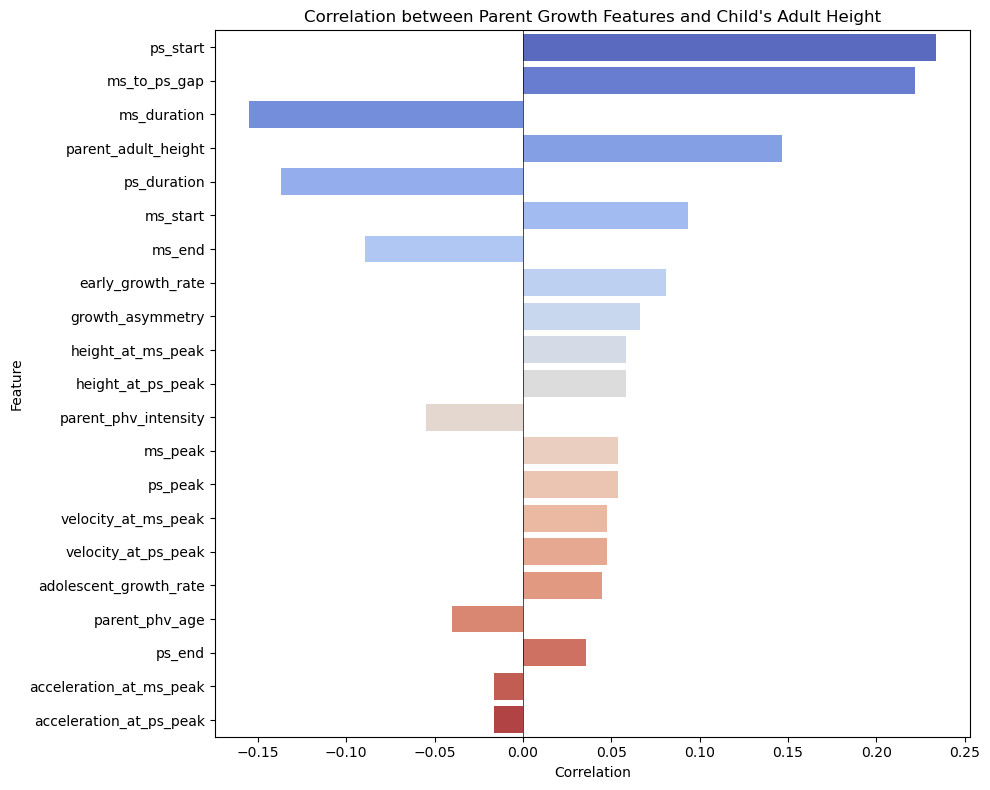


=== MODEL PERFORMANCE SUMMARY ===

Linear Regression:
  R² Score: -0.0019
  RMSE: 21.03 cm

Random Forest:
  R² Score: -0.0194
  RMSE: 21.22 cm

=== TOP 5 FEATURES BY IMPORTANCE ===

adolescent_growth_rate:
  RF Importance: 0.1332

ps_start:
  RF Importance: 0.1237

ms_to_ps_gap:
  RF Importance: 0.1094

growth_asymmetry:
  RF Importance: 0.0814

parent_phv_intensity:
  RF Importance: 0.0670


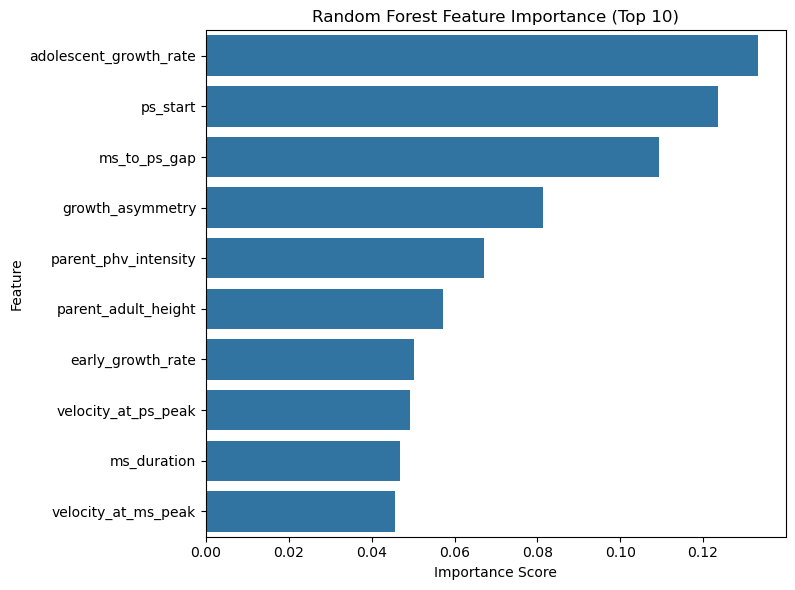


=== INDIVIDUAL FEATURE ANALYSIS ===

Statistically Significant Features (p < 0.05):

ps_start:
  Correlation (r): 0.2335
  P-value: 4.0276e-03
  Effect: weak positive
  Sample size: 150

ms_to_ps_gap:
  Correlation (r): 0.2221
  P-value: 6.2931e-03
  Effect: weak positive
  Sample size: 150

=== PARENT-CHILD SEX COMBINATION ANALYSIS ===

ANOVA Test for Height Differences Between Sex Combinations:
  F-statistic: 913.0819
  P-value: 0.0000e+00
  Interpretation: Significant differences exist between groups (α=0.05)

Height Statistics by Sex Combination:

F-M (n=28512):
  Mean height: 167.21 cm
  SD height: 6.02 cm

M-M (n=32472):
  Mean height: 170.94 cm
  SD height: 21.21 cm

F-F (n=32472):
  Mean height: 162.88 cm
  SD height: 20.61 cm

M-F (n=25344):
  Mean height: 168.88 cm
  SD height: 27.70 cm

Post-hoc Pairwise t-tests (Bonferroni corrected):
  F-M vs M-M:
    t-statistic: -30.2760
    p-value: 5.2781e-199
    Significant: Yes (α=0.0083)
    Mean difference: -3.72 cm
  F-M vs F-F:

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
from sklearn.preprocessing import StandardScaler


parent_child_data = pd.merge(
    gen2_train[
        [
            "gen2_id",
            "parent_adult_height",
            "parent_phv_age",
            "parent_phv_intensity",
            "SHgt_cm",
            "study_parent_id_new",
            "has_parent_data",
            "sex_assigned_at_birth",
        ]
    ],
    gen1_train,
    left_on="study_parent_id_new",
    right_on="gen1_id",
    suffixes=("_child", "_parent"),
)

parent_child_data = parent_child_data[parent_child_data["has_parent_data"] == 1]

parent_child_data["sex_combination"] = (
    parent_child_data["sex_assigned_at_birth_child"]
    + "-"
    + parent_child_data["sex_assigned_at_birth_parent"]
)

child_adult_heights = gen2_train.groupby("gen2_id")["SHgt_cm"].last().reset_index()
child_adult_heights.rename(columns={"SHgt_cm": "child_adult_height"}, inplace=True)

parent_child_data = pd.merge(
    parent_child_data, child_adult_heights, left_on="gen2_id", right_on="gen2_id"
)

parent_features = [
    "early_growth_rate",
    "adolescent_growth_rate",
    "parent_adult_height",
    "parent_phv_age",
    "parent_phv_intensity",
    "ms_start",
    "ms_peak",
    "ms_end",
    "ps_start",
    "ps_peak",
    "ps_end",
    "ms_duration",
    "ps_duration",
    "ms_to_ps_gap",
    "height_at_ms_peak",
    "height_at_ps_peak",
    "velocity_at_ms_peak",
    "velocity_at_ps_peak",
    "acceleration_at_ms_peak",
    "acceleration_at_ps_peak",
    "growth_asymmetry",
]

correlation_data = parent_child_data.drop_duplicates("gen2_id")[
    parent_features + ["child_adult_height"]
]
correlations = []
for feature in parent_features:
    corr = correlation_data[feature].corr(correlation_data["child_adult_height"])
    correlations.append((feature, corr))

correlations.sort(key=lambda x: abs(x[1]), reverse=True)

corr_df = pd.DataFrame(correlations, columns=["Feature", "Correlation"])

plt.figure(figsize=(10, 8))
sns.barplot(x="Correlation", y="Feature", data=corr_df, palette="coolwarm")
plt.title("Correlation between Parent Growth Features and Child's Adult Height")
plt.axvline(x=0, color="black", linestyle="-", linewidth=0.5)
plt.tight_layout()
plt.show()

X = parent_child_data.drop_duplicates("gen2_id")[parent_features]
y = parent_child_data.drop_duplicates("gen2_id")["child_adult_height"]

X = X.fillna(X.mean())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
}

results = {}
feature_importances = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[name] = {"R²": r2, "RMSE": rmse}

    if name == "Random Forest":
        feature_importances[name] = model.feature_importances_

print("\n=== MODEL PERFORMANCE SUMMARY ===")
for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"  R² Score: {metrics['R²']:.4f}")
    print(f"  RMSE: {metrics['RMSE']:.2f} cm")

importance_df = pd.DataFrame(
    {
        "Feature": parent_features,
        "RF_Importance": feature_importances["Random Forest"],
    }
).sort_values("RF_Importance", ascending=False)

print("\n=== TOP 5 FEATURES BY IMPORTANCE ===")
for idx, row in importance_df.head(5).iterrows():
    print(f"\n{row['Feature']}:")
    print(f"  RF Importance: {row['RF_Importance']:.4f}")

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(x="RF_Importance", y="Feature", data=importance_df.head(10))
plt.title("Random Forest Feature Importance (Top 10)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

print("\n=== INDIVIDUAL FEATURE ANALYSIS ===")
feature_stats = []

for feature in parent_features:
    valid_data = parent_child_data.drop_duplicates("gen2_id").dropna(
        subset=[feature, "child_adult_height"]
    )

    if len(valid_data) > 10:
        r, p = stats.pearsonr(valid_data[feature], valid_data["child_adult_height"])
        significance = "significant" if p < 0.05 else "not significant"

        if abs(r) > 0.5:
            strength = "strong"
        elif abs(r) > 0.3:
            strength = "moderate"
        elif abs(r) > 0.1:
            strength = "weak"
        else:
            strength = "negligible"

        feature_stats.append(
            {
                "Feature": feature,
                "Correlation": r,
                "P-value": p,
                "Sample Size": len(valid_data),
                "Significance": significance,
                "Effect": strength,
                "Direction": "positive" if r > 0 else "negative",
            }
        )

feature_stats_df = pd.DataFrame(feature_stats)
feature_stats_df = feature_stats_df.sort_values("Correlation", key=abs, ascending=False)

sig_features = feature_stats_df[feature_stats_df["Significance"] == "significant"]
print("\nStatistically Significant Features (p < 0.05):")
for idx, row in sig_features.iterrows():
    print(f"\n{row['Feature']}:")
    print(f"  Correlation (r): {row['Correlation']:.4f}")
    print(f"  P-value: {row['P-value']:.4e}")
    print(f"  Effect: {row['Effect']} {row['Direction']}")
    print(f"  Sample size: {row['Sample Size']}")

print("\n=== PARENT-CHILD SEX COMBINATION ANALYSIS ===")
sex_combinations = parent_child_data["sex_combination"].unique()
sex_combo_stats = []

for sex_combo in sex_combinations:
    combo_data = parent_child_data[parent_child_data["sex_combination"] == sex_combo]
    if len(combo_data) >= 20:
        sex_combo_stats.append(
            {
                "Combination": sex_combo,
                "Sample Size": len(combo_data),
                "Mean Height": combo_data["child_adult_height"].mean(),
                "SD Height": combo_data["child_adult_height"].std(),
            }
        )

sex_combo_df = pd.DataFrame(sex_combo_stats)

if len(sex_combo_df) > 1:
    groups = []
    for combo in sex_combo_df["Combination"]:
        group_data = parent_child_data[parent_child_data["sex_combination"] == combo][
            "child_adult_height"
        ]
        groups.append(group_data)

    f_stat, p_value = stats.f_oneway(*groups)

    print("\nANOVA Test for Height Differences Between Sex Combinations:")
    print(f"  F-statistic: {f_stat:.4f}")
    print(f"  P-value: {p_value:.4e}")
    print(
        f"  Interpretation: {'Significant differences exist' if p_value < 0.05 else 'No significant differences'} between groups (α=0.05)"
    )

print("\nHeight Statistics by Sex Combination:")
for idx, row in sex_combo_df.iterrows():
    print(f"\n{row['Combination']} (n={row['Sample Size']}):")
    print(f"  Mean height: {row['Mean Height']:.2f} cm")
    print(f"  SD height: {row['SD Height']:.2f} cm")

if len(sex_combo_df) > 1 and p_value < 0.05:
    print("\nPost-hoc Pairwise t-tests (Bonferroni corrected):")
    from itertools import combinations

    combo_pairs = list(combinations(sex_combo_df["Combination"], 2))
    alpha = 0.05 / len(combo_pairs)

    for combo1, combo2 in combo_pairs:
        group1 = parent_child_data[parent_child_data["sex_combination"] == combo1][
            "child_adult_height"
        ]
        group2 = parent_child_data[parent_child_data["sex_combination"] == combo2][
            "child_adult_height"
        ]

        t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)

        print(f"  {combo1} vs {combo2}:")
        print(f"    t-statistic: {t_stat:.4f}")
        print(f"    p-value: {p_val:.4e}")
        print(f"    Significant: {'Yes' if p_val < alpha else 'No'} (α={alpha:.4f})")
        print(f"    Mean difference: {group1.mean() - group2.mean():.2f} cm")

print("\n=== KEY FINDINGS SUMMARY ===")
print(f"\n1. Model Performance:")
best_model = max(results.items(), key=lambda x: x[1]["R²"])[0]
print(f"   - Best model: {best_model}")
print(f"   - R² Score: {results[best_model]['R²']:.4f}")
print(f"   - RMSE: {results[best_model]['RMSE']:.2f} cm")

print("\n2. Top 3 Most Important Parent Features:")
for i in range(min(3, len(importance_df))):
    feature = importance_df.iloc[i]
    print(f"   {i + 1}. {feature['Feature']}")
    print(f"      - RF Importance: {feature['RF_Importance']:.4f}")

print("\n3. Strongest Correlations with Child Height:")
for i in range(min(3, len(sig_features))):
    feature = sig_features.iloc[i]
    print(
        f"   {i + 1}. {feature['Feature']}: r={feature['Correlation']:.4f}, p={feature['P-value']:.4e}"
    )
    print(f"      - {feature['Effect']} {feature['Direction']} relationship")

if len(sex_combo_df) > 1:
    print(f"\n4. Sex Combination Analysis:")
    print(f"   - ANOVA p-value: {p_value:.4e}")
    print(
        f"   - {'Significant' if p_value < 0.05 else 'No significant'} differences between sex combinations"
    )

## b. What features of a parent’s growth curve are most predictive (if at all) of the magnitude (amount grown) of a child’s pubertal growth spurt, typically occurring between the ages of 9 and 15)?


In [7]:
def calculate_pubertal_growth_magnitude(df):
    """Calculate the magnitude of pubertal growth spurt for each individual"""
    results = []

    for subject_id in df["gen2_id"].unique():
        subject_data = df[df["gen2_id"] == subject_id]

        # Check if we have the necessary data
        if "ps_start" in subject_data.columns and "ps_end" in subject_data.columns:
            ps_start = subject_data["ps_start"].iloc[0]
            ps_end = subject_data["ps_end"].iloc[0]

            if not pd.isna(ps_start) and not pd.isna(ps_end):
                # Find heights at these ages or closest available
                height_at_start = subject_data.iloc[
                    (subject_data["AgeGr"] - ps_start).abs().argsort()[:1]
                ]["SHgt_cm"].values[0]

                height_at_end = subject_data.iloc[
                    (subject_data["AgeGr"] - ps_end).abs().argsort()[:1]
                ]["SHgt_cm"].values[0]

                # Calculate magnitude
                growth_magnitude = height_at_end - height_at_start

                # Add growth magnitude to the subject's data
                subject_row = subject_data.iloc[0].copy()
                subject_row["pubertal_growth_magnitude"] = growth_magnitude
                results.append(subject_row)

    # Convert to DataFrame and keep all original columns
    return pd.DataFrame(results)


# Calculate pubertal growth magnitude for Gen2
gen2_growth_magnitude = calculate_pubertal_growth_magnitude(gen2_train)
gen2_growth_magnitude

,gen2_id,sex_assigned_at_birth,study_parent_sex,study_parent_id_new,AgeGr,SHgt_cm,Wgt_kg,SHgt_cm_smooth,height_velocity,early_growth_rate,...,height_age_correlation_missing,velocity_pattern_correlation_missing,parent_phv_age_missing,parent_phv_intensity_missing,mean_height_ratio_missing,expected_adult_height_missing,is_female,is_same_sex_as_parent,height_percentile_sex,pubertal_growth_magnitude
0,1332,F,father,724,0.1,54.098866,18.839206,53.789445,5.61913,11.972359,...,1,1,1,1,1,1,1,0,0.273684,14.960175
22,2330,F,mother,262,0.1,66.362172,16.204488,66.604816,5.61913,8.808274,...,1,1,1,1,1,1,1,1,0.968421,9.914192
44,2331,M,mother,274,0.1,57.920127,18.465756,57.815434,5.61913,9.711133,...,1,1,1,1,1,1,0,0,0.604167,30.291187
66,2505,F,father,668,0.1,58.894508,20.744253,58.850520,5.61913,10.667283,...,1,1,1,1,1,1,1,0,0.715789,11.406049
88,2507,F,father,350,0.1,54.436597,19.710666,54.335227,5.61913,12.123083,...,1,1,1,1,1,1,1,0,0.347368,14.537348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4092,2825,M,mother,570,0.1,54.033054,20.289783,53.964546,5.61913,11.485612,...,0,0,0,0,0,0,0,0,0.135417,12.873453
4114,2827,M,mother,744,0.1,54.059864,17.741160,54.100975,5.61913,9.991612,...,1,1,1,1,1,1,0,0,0.145833,14.912526
4136,2829,F,father,662,0.1,50.388464,17.981339,50.267662,5.61913,11.416160,...,0,0,0,0,0,0,1,0,0.021053,19.354843
4158,2830,F,mother,712,0.1,55.222683,20.813682,55.006914,5.61913,11.509519,...,0,0,0,0,0,0,1,1,0.400000,-7.228528


/var/folders/pf/k196hws969g1q7_pkdnv68ww0000gn/T/ipykernel_45457/2269359023.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Correlation", y="Feature", data=corr_df, palette="coolwarm")


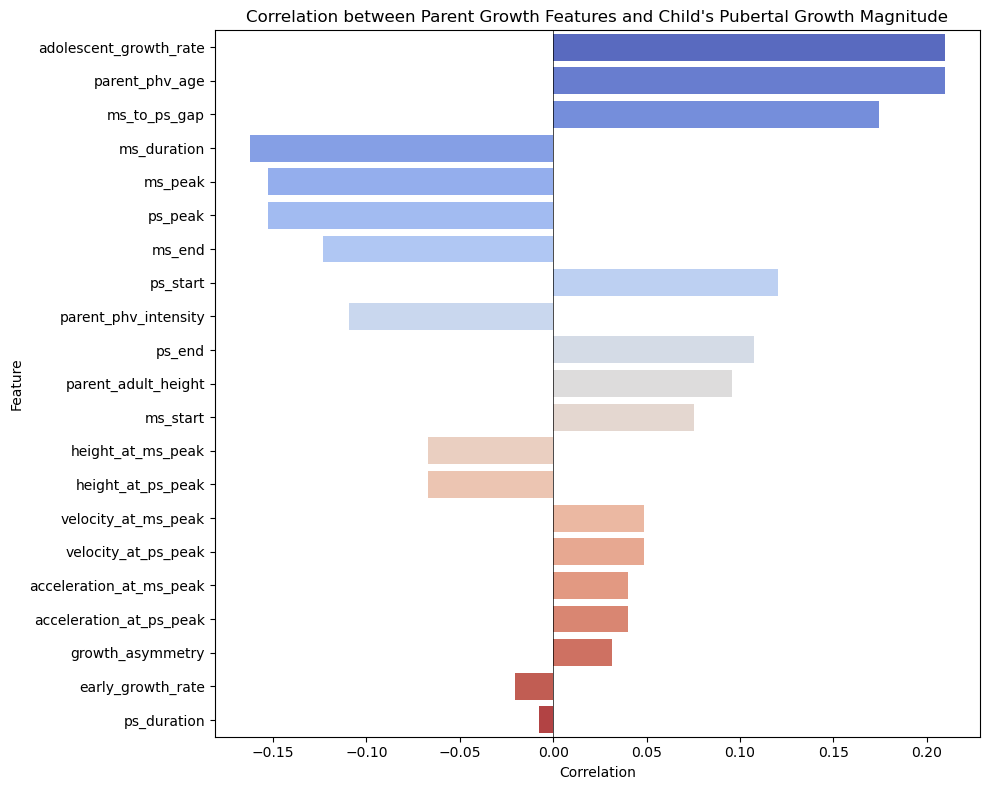


=== MODEL PERFORMANCE SUMMARY ===

Linear Regression:
  R² Score: 0.1761
  RMSE: 11.25 cm

Random Forest:
  R² Score: 0.6371
  RMSE: 7.46 cm

=== TOP 5 FEATURES BY IMPORTANCE ===

adolescent_growth_rate:
  RF Importance: 0.1668

parent_phv_intensity:
  RF Importance: 0.1357

parent_phv_age:
  RF Importance: 0.1066

parent_adult_height:
  RF Importance: 0.0619

height_at_ps_peak:
  RF Importance: 0.0534


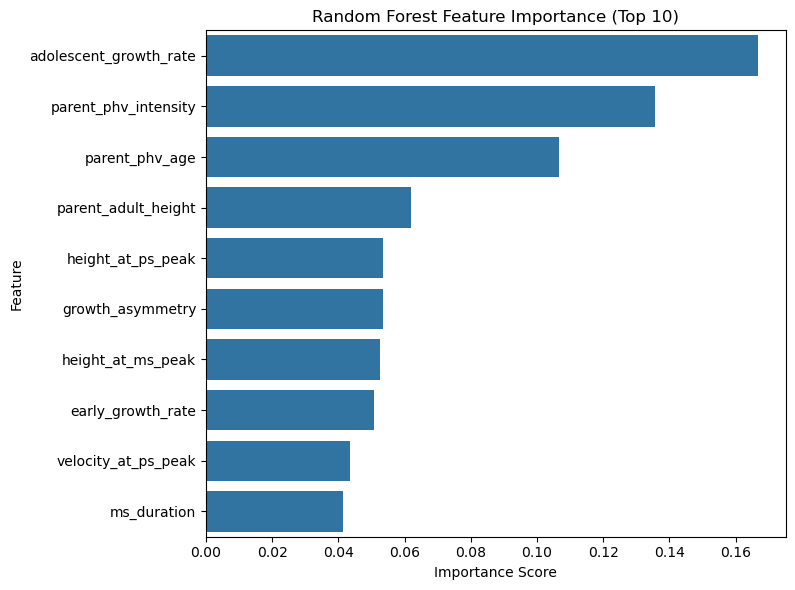


=== INDIVIDUAL FEATURE ANALYSIS ===

Statistically Significant Features (p < 0.05):

adolescent_growth_rate:
  Correlation (r): 0.2099
  P-value: 9.9298e-03
  Effect: weak positive
  Sample size: 150

parent_phv_age:
  Correlation (r): 0.2099
  P-value: 9.9400e-03
  Effect: weak positive
  Sample size: 150

ms_to_ps_gap:
  Correlation (r): 0.1744
  P-value: 3.2792e-02
  Effect: weak positive
  Sample size: 150

ms_duration:
  Correlation (r): -0.1625
  P-value: 4.6904e-02
  Effect: weak negative
  Sample size: 150

=== PARENT-CHILD SEX COMBINATION ANALYSIS ===

ANOVA Test for Height Differences Between Sex Combinations:
  F-statistic: 152.5092
  P-value: 7.1240e-95
  Interpretation: Significant differences exist between groups (α=0.05)

Height Statistics by Sex Combination:

F-M (n=1296):
  Mean height: 15.70 cm
  SD height: 9.99 cm

M-M (n=1476):
  Mean height: 13.27 cm
  SD height: 15.12 cm

F-F (n=1476):
  Mean height: 7.39 cm
  SD height: 11.08 cm

M-F (n=1152):
  Mean height: 16.

In [8]:
# Merge parent and child data
parent_child_data = pd.merge(
    gen2_growth_magnitude[
        [
            "gen2_id",
            "parent_adult_height",
            "parent_phv_age",
            "parent_phv_intensity",
            "SHgt_cm",
            "study_parent_id_new",
            "has_parent_data",
            "sex_assigned_at_birth",
            "pubertal_growth_magnitude",
        ]
    ],
    gen1_train,
    left_on="study_parent_id_new",
    right_on="gen1_id",
    suffixes=("_child", "_parent"),
)

# Filter to only include children with parent data
parent_child_data = parent_child_data.dropna(subset=["pubertal_growth_magnitude"])

# Create sex_combination column
parent_child_data["sex_combination"] = (
    parent_child_data["sex_assigned_at_birth_child"]
    + "-"
    + parent_child_data["sex_assigned_at_birth_parent"]
)

# Define parent features that might be predictive
parent_features = [
    "early_growth_rate",
    "adolescent_growth_rate",
    "parent_adult_height",
    "parent_phv_age",
    "parent_phv_intensity",
    "ms_start",
    "ms_peak",
    "ms_end",
    "ps_start",
    "ps_peak",
    "ps_end",
    "ms_duration",
    "ps_duration",
    "ms_to_ps_gap",
    "height_at_ms_peak",
    "height_at_ps_peak",
    "velocity_at_ms_peak",
    "velocity_at_ps_peak",
    "acceleration_at_ms_peak",
    "acceleration_at_ps_peak",
    "growth_asymmetry",
]

# Correlation analysis
correlation_data = parent_child_data.drop_duplicates("gen2_id")[
    parent_features + ["pubertal_growth_magnitude"]
]
correlations = []
for feature in parent_features:
    corr = correlation_data[feature].corr(correlation_data["pubertal_growth_magnitude"])
    correlations.append((feature, corr))

correlations.sort(key=lambda x: abs(x[1]), reverse=True)

corr_df = pd.DataFrame(correlations, columns=["Feature", "Correlation"])

plt.figure(figsize=(10, 8))
sns.barplot(x="Correlation", y="Feature", data=corr_df, palette="coolwarm")
plt.title(
    "Correlation between Parent Growth Features and Child's Pubertal Growth Magnitude"
)
plt.axvline(x=0, color="black", linestyle="-", linewidth=0.5)
plt.tight_layout()
plt.show()

# Prepare data for modeling
X = parent_child_data[parent_features]
y = parent_child_data["pubertal_growth_magnitude"]

# Handle missing values
X = X.fillna(X.mean())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
}

results = {}
feature_importances = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[name] = {"R²": r2, "RMSE": rmse}

    if name == "Random Forest":
        feature_importances[name] = model.feature_importances_

print("\n=== MODEL PERFORMANCE SUMMARY ===")
for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"  R² Score: {metrics['R²']:.4f}")
    print(f"  RMSE: {metrics['RMSE']:.2f} cm")

importance_df = pd.DataFrame(
    {
        "Feature": parent_features,
        "RF_Importance": feature_importances["Random Forest"],
    }
).sort_values("RF_Importance", ascending=False)

print("\n=== TOP 5 FEATURES BY IMPORTANCE ===")
for idx, row in importance_df.head(5).iterrows():
    print(f"\n{row['Feature']}:")
    print(f"  RF Importance: {row['RF_Importance']:.4f}")

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(x="RF_Importance", y="Feature", data=importance_df.head(10))
plt.title("Random Forest Feature Importance (Top 10)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

print("\n=== INDIVIDUAL FEATURE ANALYSIS ===")
feature_stats = []

for feature in parent_features:
    valid_data = parent_child_data.drop_duplicates("gen2_id").dropna(
        subset=[feature, "pubertal_growth_magnitude"]
    )

    if len(valid_data) > 10:
        r, p = stats.pearsonr(
            valid_data[feature], valid_data["pubertal_growth_magnitude"]
        )
        significance = "significant" if p < 0.05 else "not significant"

        if abs(r) > 0.5:
            strength = "strong"
        elif abs(r) > 0.3:
            strength = "moderate"
        elif abs(r) > 0.1:
            strength = "weak"
        else:
            strength = "negligible"

        feature_stats.append(
            {
                "Feature": feature,
                "Correlation": r,
                "P-value": p,
                "Sample Size": len(valid_data),
                "Significance": significance,
                "Effect": strength,
                "Direction": "positive" if r > 0 else "negative",
            }
        )

feature_stats_df = pd.DataFrame(feature_stats)
feature_stats_df = feature_stats_df.sort_values("Correlation", key=abs, ascending=False)

sig_features = feature_stats_df[feature_stats_df["Significance"] == "significant"]
print("\nStatistically Significant Features (p < 0.05):")
for idx, row in sig_features.iterrows():
    print(f"\n{row['Feature']}:")
    print(f"  Correlation (r): {row['Correlation']:.4f}")
    print(f"  P-value: {row['P-value']:.4e}")
    print(f"  Effect: {row['Effect']} {row['Direction']}")
    print(f"  Sample size: {row['Sample Size']}")

print("\n=== PARENT-CHILD SEX COMBINATION ANALYSIS ===")
sex_combinations = parent_child_data["sex_combination"].unique()
sex_combo_stats = []

for sex_combo in sex_combinations:
    combo_data = parent_child_data[parent_child_data["sex_combination"] == sex_combo]
    if len(combo_data) >= 20:
        sex_combo_stats.append(
            {
                "Combination": sex_combo,
                "Sample Size": len(combo_data),
                "Mean Height": combo_data["pubertal_growth_magnitude"].mean(),
                "SD Height": combo_data["pubertal_growth_magnitude"].std(),
            }
        )

sex_combo_df = pd.DataFrame(sex_combo_stats)

if len(sex_combo_df) > 1:
    groups = []
    for combo in sex_combo_df["Combination"]:
        group_data = parent_child_data[parent_child_data["sex_combination"] == combo][
            "pubertal_growth_magnitude"
        ]
        groups.append(group_data)

    f_stat, p_value = stats.f_oneway(*groups)

    print("\nANOVA Test for Height Differences Between Sex Combinations:")
    print(f"  F-statistic: {f_stat:.4f}")
    print(f"  P-value: {p_value:.4e}")
    print(
        f"  Interpretation: {'Significant differences exist' if p_value < 0.05 else 'No significant differences'} between groups (α=0.05)"
    )

print("\nHeight Statistics by Sex Combination:")
for idx, row in sex_combo_df.iterrows():
    print(f"\n{row['Combination']} (n={row['Sample Size']}):")
    print(f"  Mean height: {row['Mean Height']:.2f} cm")
    print(f"  SD height: {row['SD Height']:.2f} cm")

if len(sex_combo_df) > 1 and p_value < 0.05:
    print("\nPost-hoc Pairwise t-tests (Bonferroni corrected):")
    from itertools import combinations

    combo_pairs = list(combinations(sex_combo_df["Combination"], 2))
    alpha = 0.05 / len(combo_pairs)

    for combo1, combo2 in combo_pairs:
        group1 = parent_child_data[parent_child_data["sex_combination"] == combo1][
            "pubertal_growth_magnitude"
        ]
        group2 = parent_child_data[parent_child_data["sex_combination"] == combo2][
            "pubertal_growth_magnitude"
        ]

        t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)

        print(f"  {combo1} vs {combo2}:")
        print(f"    t-statistic: {t_stat:.4f}")
        print(f"    p-value: {p_val:.4e}")
        print(f"    Significant: {'Yes' if p_val < alpha else 'No'} (α={alpha:.4f})")
        print(f"    Mean difference: {group1.mean() - group2.mean():.2f} cm")

print("\n=== KEY FINDINGS SUMMARY ===")
print(f"\n1. Model Performance:")
best_model = max(results.items(), key=lambda x: x[1]["R²"])[0]
print(f"   - Best model: {best_model}")
print(f"   - R² Score: {results[best_model]['R²']:.4f}")
print(f"   - RMSE: {results[best_model]['RMSE']:.2f} cm")

print("\n2. Top 3 Most Important Parent Features:")
for i in range(min(3, len(importance_df))):
    feature = importance_df.iloc[i]
    print(f"   {i + 1}. {feature['Feature']}")
    print(f"      - RF Importance: {feature['RF_Importance']:.4f}")

print("\n3. Strongest Correlations with Child Height:")
for i in range(min(3, len(sig_features))):
    feature = sig_features.iloc[i]
    print(
        f"   {i + 1}. {feature['Feature']}: r={feature['Correlation']:.4f}, p={feature['P-value']:.4e}"
    )
    print(f"      - {feature['Effect']} {feature['Direction']} relationship")

if len(sex_combo_df) > 1:
    print(f"\n4. Sex Combination Analysis:")
    print(f"   - ANOVA p-value: {p_value:.4e}")
    print(
        f"   - {'Significant' if p_value < 0.05 else 'No significant'} differences between sex combinations"
    )

## c. What features of a parent’s growth curve are most predictive (if at all) of the timing (onset and duration) of a child’s pubertal growth spurt, typically occurring between the ages of 9 and 15?

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import argrelextrema
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings("ignore")

In [10]:
gen1_train = pd.read_csv("./data/gen1_train.csv")
gen2_train = pd.read_csv("./data/gen2_train.csv")

In [11]:
gen1_features = extract_growth_features(gen1_train, id_col='gen1_id', age_col='age', height_col='SHgt_cm')
gen2_features = extract_growth_features(gen2_train, id_col='gen2_id', age_col='AgeGr', height_col='SHgt_cm')

gen1_growth = calculate_growth_features(gen1_train, id_col='gen1_id', age_col='age')
gen2_growth = calculate_growth_features(gen2_train, id_col='gen2_id', age_col='AgeGr')

gen1_features = gen1_features.merge(gen1_growth[['gen1_id', 'adolescent_growth_rate']], on='gen1_id', how='left')
gen2_features = gen2_features.merge(gen2_growth[['gen2_id', 'adolescent_growth_rate']], on='gen2_id', how='left')

gen2_train["height_velocity"] = gen2_train.groupby("gen2_id")["SHgt_cm"].diff()
peak_velocity_age = gen2_train.loc[gen2_train.groupby("gen2_id")["height_velocity"].idxmax(), ["gen2_id", "AgeGr"]]
peak_velocity_age.rename(columns={"AgeGr": "child_peak_velocity_age"}, inplace=True)

# 💅 Merge all relevant features
gen2_features = gen2_features.merge(peak_velocity_age, on="gen2_id", how="left")
gen2_features.dropna(inplace=True)

In [12]:
X = gen2_features.drop(columns=["gen2_id", "child_peak_velocity_age"])
y_peak_velocity_age = gen2_features["child_peak_velocity_age"]

In [13]:
rf_peak_velocity = RandomForestRegressor(n_estimators=100, random_state=42)
rf_peak_velocity.fit(X, y_peak_velocity_age)

RandomForestRegressor(random_state=42)

In [14]:
feature_importance_peak_velocity = rf_peak_velocity.feature_importances_

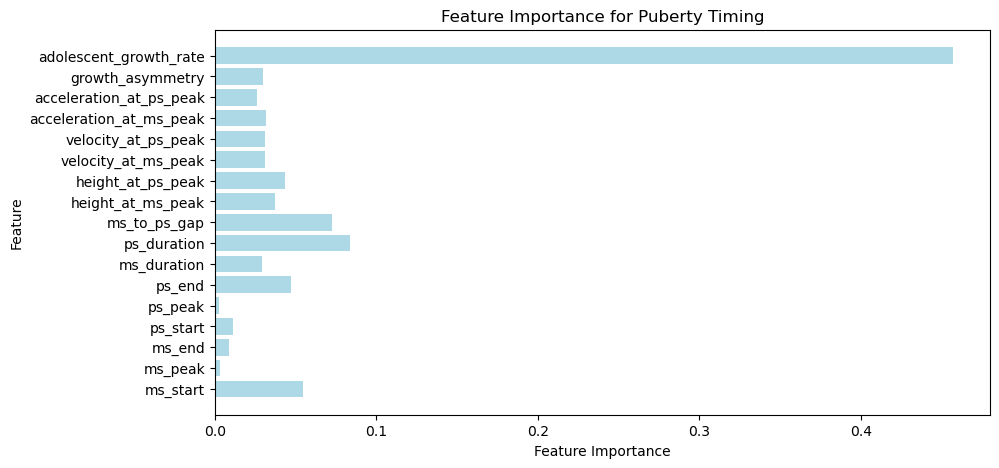

In [15]:
# 💅 (c) Puberty Timing Feature Importance Plot**
plt.figure(figsize=(10, 5))
plt.barh(X.columns, feature_importance_peak_velocity, color="lightblue")
plt.title("Feature Importance for Puberty Timing")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

## d. For questions b. and c., does the strength of heredity change depending on the relationship between parent/child sexes assigned at birth? (E.g. parent/child combinations of matched sexes – M/M, F/F, or opposite sexes – M/F, F/M.) If yes, how do these associations change in each case?

In [16]:
gen2_features = gen2_features.merge(
    gen2_train[['gen2_id', 'sex_assigned_at_birth', 'study_parent_sex']], 
    on='gen2_id', how='left'
)

if "child_final_height" not in gen2_features.columns:
    child_final_height = gen2_train.groupby("gen2_id")["SHgt_cm"].max().reset_index()
    child_final_height.rename(columns={"SHgt_cm": "child_final_height"}, inplace=True)
    gen2_features = gen2_features.merge(child_final_height, on="gen2_id", how="left")

In [17]:
gen2_features.columns

Index(['gen2_id', 'ms_start', 'ms_peak', 'ms_end', 'ps_start', 'ps_peak',
       'ps_end', 'ms_duration', 'ps_duration', 'ms_to_ps_gap',
       'height_at_ms_peak', 'height_at_ps_peak', 'velocity_at_ms_peak',
       'velocity_at_ps_peak', 'acceleration_at_ms_peak',
       'acceleration_at_ps_peak', 'growth_asymmetry', 'adolescent_growth_rate',
       'child_peak_velocity_age', 'sex_assigned_at_birth', 'study_parent_sex',
       'child_final_height'],
      dtype='object')

In [18]:
def perform_hypothesis_tests(df):
    results = {}

    # Ensure 'child_growth_spurt' is in df
    if "child_growth_spurt" not in df.columns:
        print("Merging growth spurt data into the feature set...")
        growth_spurt = gen2_train[(gen2_train["AgeGr"] >= 9) & (gen2_train["AgeGr"] <= 15)]
        growth_spurt = growth_spurt.groupby("gen2_id")["SHgt_cm"].agg(["min", "max"]).reset_index()
        growth_spurt["child_growth_spurt"] = growth_spurt["max"] - growth_spurt["min"]
        growth_spurt = growth_spurt[["gen2_id", "child_growth_spurt"]]
        df = df.merge(growth_spurt, on="gen2_id", how="left")

    # Ensure 'sex_pair' exists
    df["sex_pair"] = df["sex_assigned_at_birth"] + "/" + df["study_parent_sex"]

    ## 💅 Part (c) - Puberty Timing & Duration ~ Adolescent Growth Rate
    model_ps_onset = ols("child_peak_velocity_age ~ adolescent_growth_rate", data=df).fit()
    anova_ps_onset = sm.stats.anova_lm(model_ps_onset, typ=2)
    results["(c1) ANOVA: Adolescent Growth Rate ~ Child Pubertal Growth Onset"] = (
        anova_ps_onset["F"][0], anova_ps_onset["PR(>F)"][0], model_ps_onset.rsquared)

    model_ps_duration = ols("ps_duration ~ adolescent_growth_rate", data=df).fit()
    anova_ps_duration = sm.stats.anova_lm(model_ps_duration, typ=2)
    results["(c2) ANOVA: Adolescent Growth Rate ~ Child Pubertal Growth Duration"] = (
        anova_ps_duration["F"][0], anova_ps_duration["PR(>F)"][0], model_ps_duration.rsquared)

    ## 💅 Part (d) - Sex Pair & Heredity Effects (Question b & c)

    # (d1) Growth Spurt Magnitude ~ Parent-Child Sex Pair
    model_growth_spurt = ols("child_growth_spurt ~ sex_pair", data=df).fit()
    anova_growth_spurt = sm.stats.anova_lm(model_growth_spurt, typ=2)
    results["(d1) ANOVA: Parent/Child Sex Pair ~ Growth Spurt Magnitude"] = (
        anova_growth_spurt["F"][0], anova_growth_spurt["PR(>F)"][0], model_growth_spurt.rsquared)

    # (d2) Pubertal Growth Onset ~ Parent-Child Sex Pair
    model_ps_onset_sex = ols("child_peak_velocity_age ~ sex_pair", data=df).fit()
    anova_ps_onset_sex = sm.stats.anova_lm(model_ps_onset_sex, typ=2)
    results["(d2) ANOVA: Parent/Child Sex Pair ~ Pubertal Growth Onset"] = (
        anova_ps_onset_sex["F"][0], anova_ps_onset_sex["PR(>F)"][0], model_ps_onset_sex.rsquared)

    # (d3) Pubertal Growth Duration ~ Parent-Child Sex Pair
    model_ps_duration_sex = ols("ps_duration ~ sex_pair", data=df).fit()
    anova_ps_duration_sex = sm.stats.anova_lm(model_ps_duration_sex, typ=2)
    results["(d3) ANOVA: Parent/Child Sex Pair ~ Pubertal Growth Duration"] = (
        anova_ps_duration_sex["F"][0], anova_ps_duration_sex["PR(>F)"][0], model_ps_duration_sex.rsquared)

    # (d4) Growth Spurt Onset Age ~ Parent-Child Sex Pair (from part b)
    model_spurt_onset = ols("ms_start ~ sex_pair", data=df).fit()
    anova_spurt_onset = sm.stats.anova_lm(model_spurt_onset, typ=2)
    results["(d4) ANOVA: Parent/Child Sex Pair ~ Growth Spurt Onset Age"] = (
        anova_spurt_onset["F"][0], anova_spurt_onset["PR(>F)"][0], model_spurt_onset.rsquared)

    # (d5) Adolescent Growth Rate ~ Parent-Child Sex Pair (from part b)
    model_adolescent_growth = ols("adolescent_growth_rate ~ sex_pair", data=df).fit()
    anova_adolescent_growth = sm.stats.anova_lm(model_adolescent_growth, typ=2)
    results["(d5) ANOVA: Parent/Child Sex Pair ~ Adolescent Growth Rate"] = (
        anova_adolescent_growth["F"][0], anova_adolescent_growth["PR(>F)"][0], model_adolescent_growth.rsquared)

    return results

In [19]:
hypothesis_results = perform_hypothesis_tests(gen2_features)
hypothesis_df = pd.DataFrame(hypothesis_results, index=["Test Statistic", "p-value", "R-squared"]).T

hypothesis_df

Merging growth spurt data into the feature set...


,Test Statistic,p-value,R-squared
(c1) ANOVA: Adolescent Growth Rate ~ Child Pubertal Growth Onset,31116.222257,0.0,0.251834
(c2) ANOVA: Adolescent Growth Rate ~ Child Pubertal Growth Duration,1512.685268,0.0,0.016100
(d1) ANOVA: Parent/Child Sex Pair ~ Growth Spurt Magnitude,867.874202,0.0,0.027394
(d2) ANOVA: Parent/Child Sex Pair ~ Pubertal Growth Onset,5420.850007,0.0,0.149606
(d3) ANOVA: Parent/Child Sex Pair ~ Pubertal Growth Duration,1663.937390,0.0,0.051234
(d4) ANOVA: Parent/Child Sex Pair ~ Growth Spurt Onset Age,1124.773167,0.0,0.035217
(d5) ANOVA: Parent/Child Sex Pair ~ Adolescent Growth Rate,1392.161784,0.0,0.043227
